#### Version history
* V1 - Basic training with default settings
* V2 - Added a custom evaluator to track the competition metric during training

## Training

All the heavy lifting here is done by the [detectron](https://github.com/facebookresearch/detectron2) library. What's needed from us is pointing it to the annotation files of our dataset (see [part one](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details), setting some hyperparameters and calling `trainer.train()`

Most of the code here is just for displaying things to make sure everything is set up correctly and the training worked.

In [1]:
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
import torch
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator

setup_logger()

# if torch.cuda.is_available():
#     DEVICE = torch.device('cuda')
#     print('GPU is available')
# else:
#     DEVICE = torch.device('cpu')
#     print('CPU is used')
# print('detectron ver:', detectron2.__version__)

<Logger detectron2 (DEBUG)>

### Load the competition data
This is very simple once we have our data in the COCO format. See the [part one notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details.

In [3]:
dataDir=Path('C:/kaggletemp/sartorius-cell-instance-segmentation/')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, os.path.join( dataDir ,'DETECTRON_FILES/' , 'annotations_train.json'), dataDir)
register_coco_instances('sartorius_val',{}, os.path.join( dataDir ,'DETECTRON_FILES/' , 'annotations_val.json'), dataDir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[12/30 02:30:30 d2.data.datasets.coco]: Loaded 484 images in COCO format from C:\kaggletemp\sartorius-cell-instance-segmentation\DETECTRON_FILES/annotations_train.json


### Display a sample file to check the data is loaded correctly

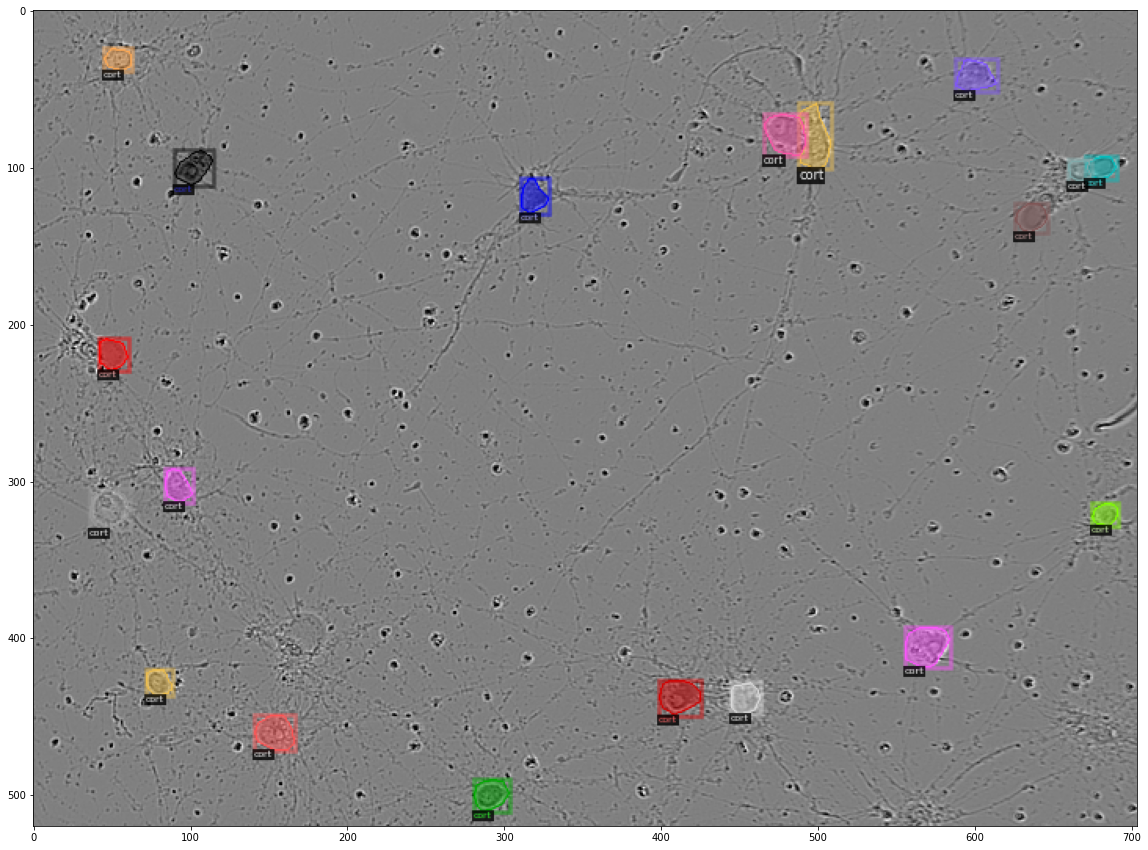

In [4]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

### Define evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [5]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    

### Train
I haven't done any hyperparameter optimization yet, this is mostly taken as is from the Detectron tutorial. 

Training for 1000 iterations here for demonstration. For a high scoring model you will need to train it longer, closer to 10000 with these settings

In [6]:
i = 2

# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.merge_from_file(model_zoo.get_config_file(  "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"  )  )
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("output/model_final_iscrowd.pth")  # Let training initialize from model zoo


cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0009
cfg.SOLVER.MAX_ITER = 10000#2 * ITERATE_PER_EPOCH
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 2 ^8
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5

ITERATE_PER_EPOCH = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH

cfg.TEST.EVAL_PERIOD = ITERATE_PER_EPOCH# len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

cfg.SOLVER.AMP.ENABLED = True
#cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
# cfg.INPUT.MIN_SIZE_TRAIN = (704,)
# cfg.INPUT.MAX_SIZE_TRAIN = 520
# cfg.INPUT.MIN_SIZE_TEST = 520
# cfg.INPUT.MAX_SIZE_TEST = 704
#cfg.MODEL.DEVICE = 'cpu' #"cuda"

cfg.OUTPUT_DIR = "./output" + str(i)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained


[12/30 02:30:32 d2.data.datasets.coco]: Loaded 484 images in COCO format from C:\kaggletemp\sartorius-cell-instance-segmentation\DETECTRON_FILES/annotations_train.json
[12/30 02:30:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
   

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[12/30 02:30:35 d2.engine.train_loop]: Starting training from iteration 0


C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[12/30 02:30:54 d2.utils.events]:  eta: 0:47:52  iter: 19  total_loss: 6.353  loss_cls: 1.325  loss_box_reg: 0.304  loss_mask: 0.6924  loss_rpn_cls: 3.806  loss_rpn_loc: 0.3446  time: 0.4376  data_time: 0.4516  lr: 1.7983e-05  max_mem: 4605M
[12/30 02:31:03 d2.utils.events]:  eta: 0:47:07  iter: 39  total_loss: 2.887  loss_cls: 1.139  loss_box_reg: 0.3524  loss_mask: 0.6876  loss_rpn_cls: 0.4408  loss_rpn_loc: 0.3248  time: 0.4543  data_time: 0.1922  lr: 3.5965e-05  max_mem: 4700M
[12/30 02:31:10 d2.utils.events]:  eta: 0:44:54  iter: 59  total_loss: 2.367  loss_cls: 0.7686  loss_box_reg: 0.4232  loss_mask: 0.6746  loss_rpn_cls: 0.2735  loss_rpn_loc: 0.2787  time: 0.4158  data_time: 0.0869  lr: 5.3947e-05  max_mem: 4700M
[12/30 02:31:14 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x000001E030C6DD38> to CPU due to CUDA OOM
[12/30 02:31:25 d2.utils.events]:  eta: 0:46:31  iter: 79  total_loss: 2.355  loss_cls: 0.6812  loss_box_reg: 0.4462  loss_mask: 0.6707  

In [7]:
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

### Lets look at some of the validation files to check if things look reasonable
We show predictions on the left and ground truth on the right

[12/30 04:20:34 d2.data.datasets.coco]: Loaded 122 images in COCO format from C:\kaggletemp\sartorius-cell-instance-segmentation\DETECTRON_FILES/annotations_val.json


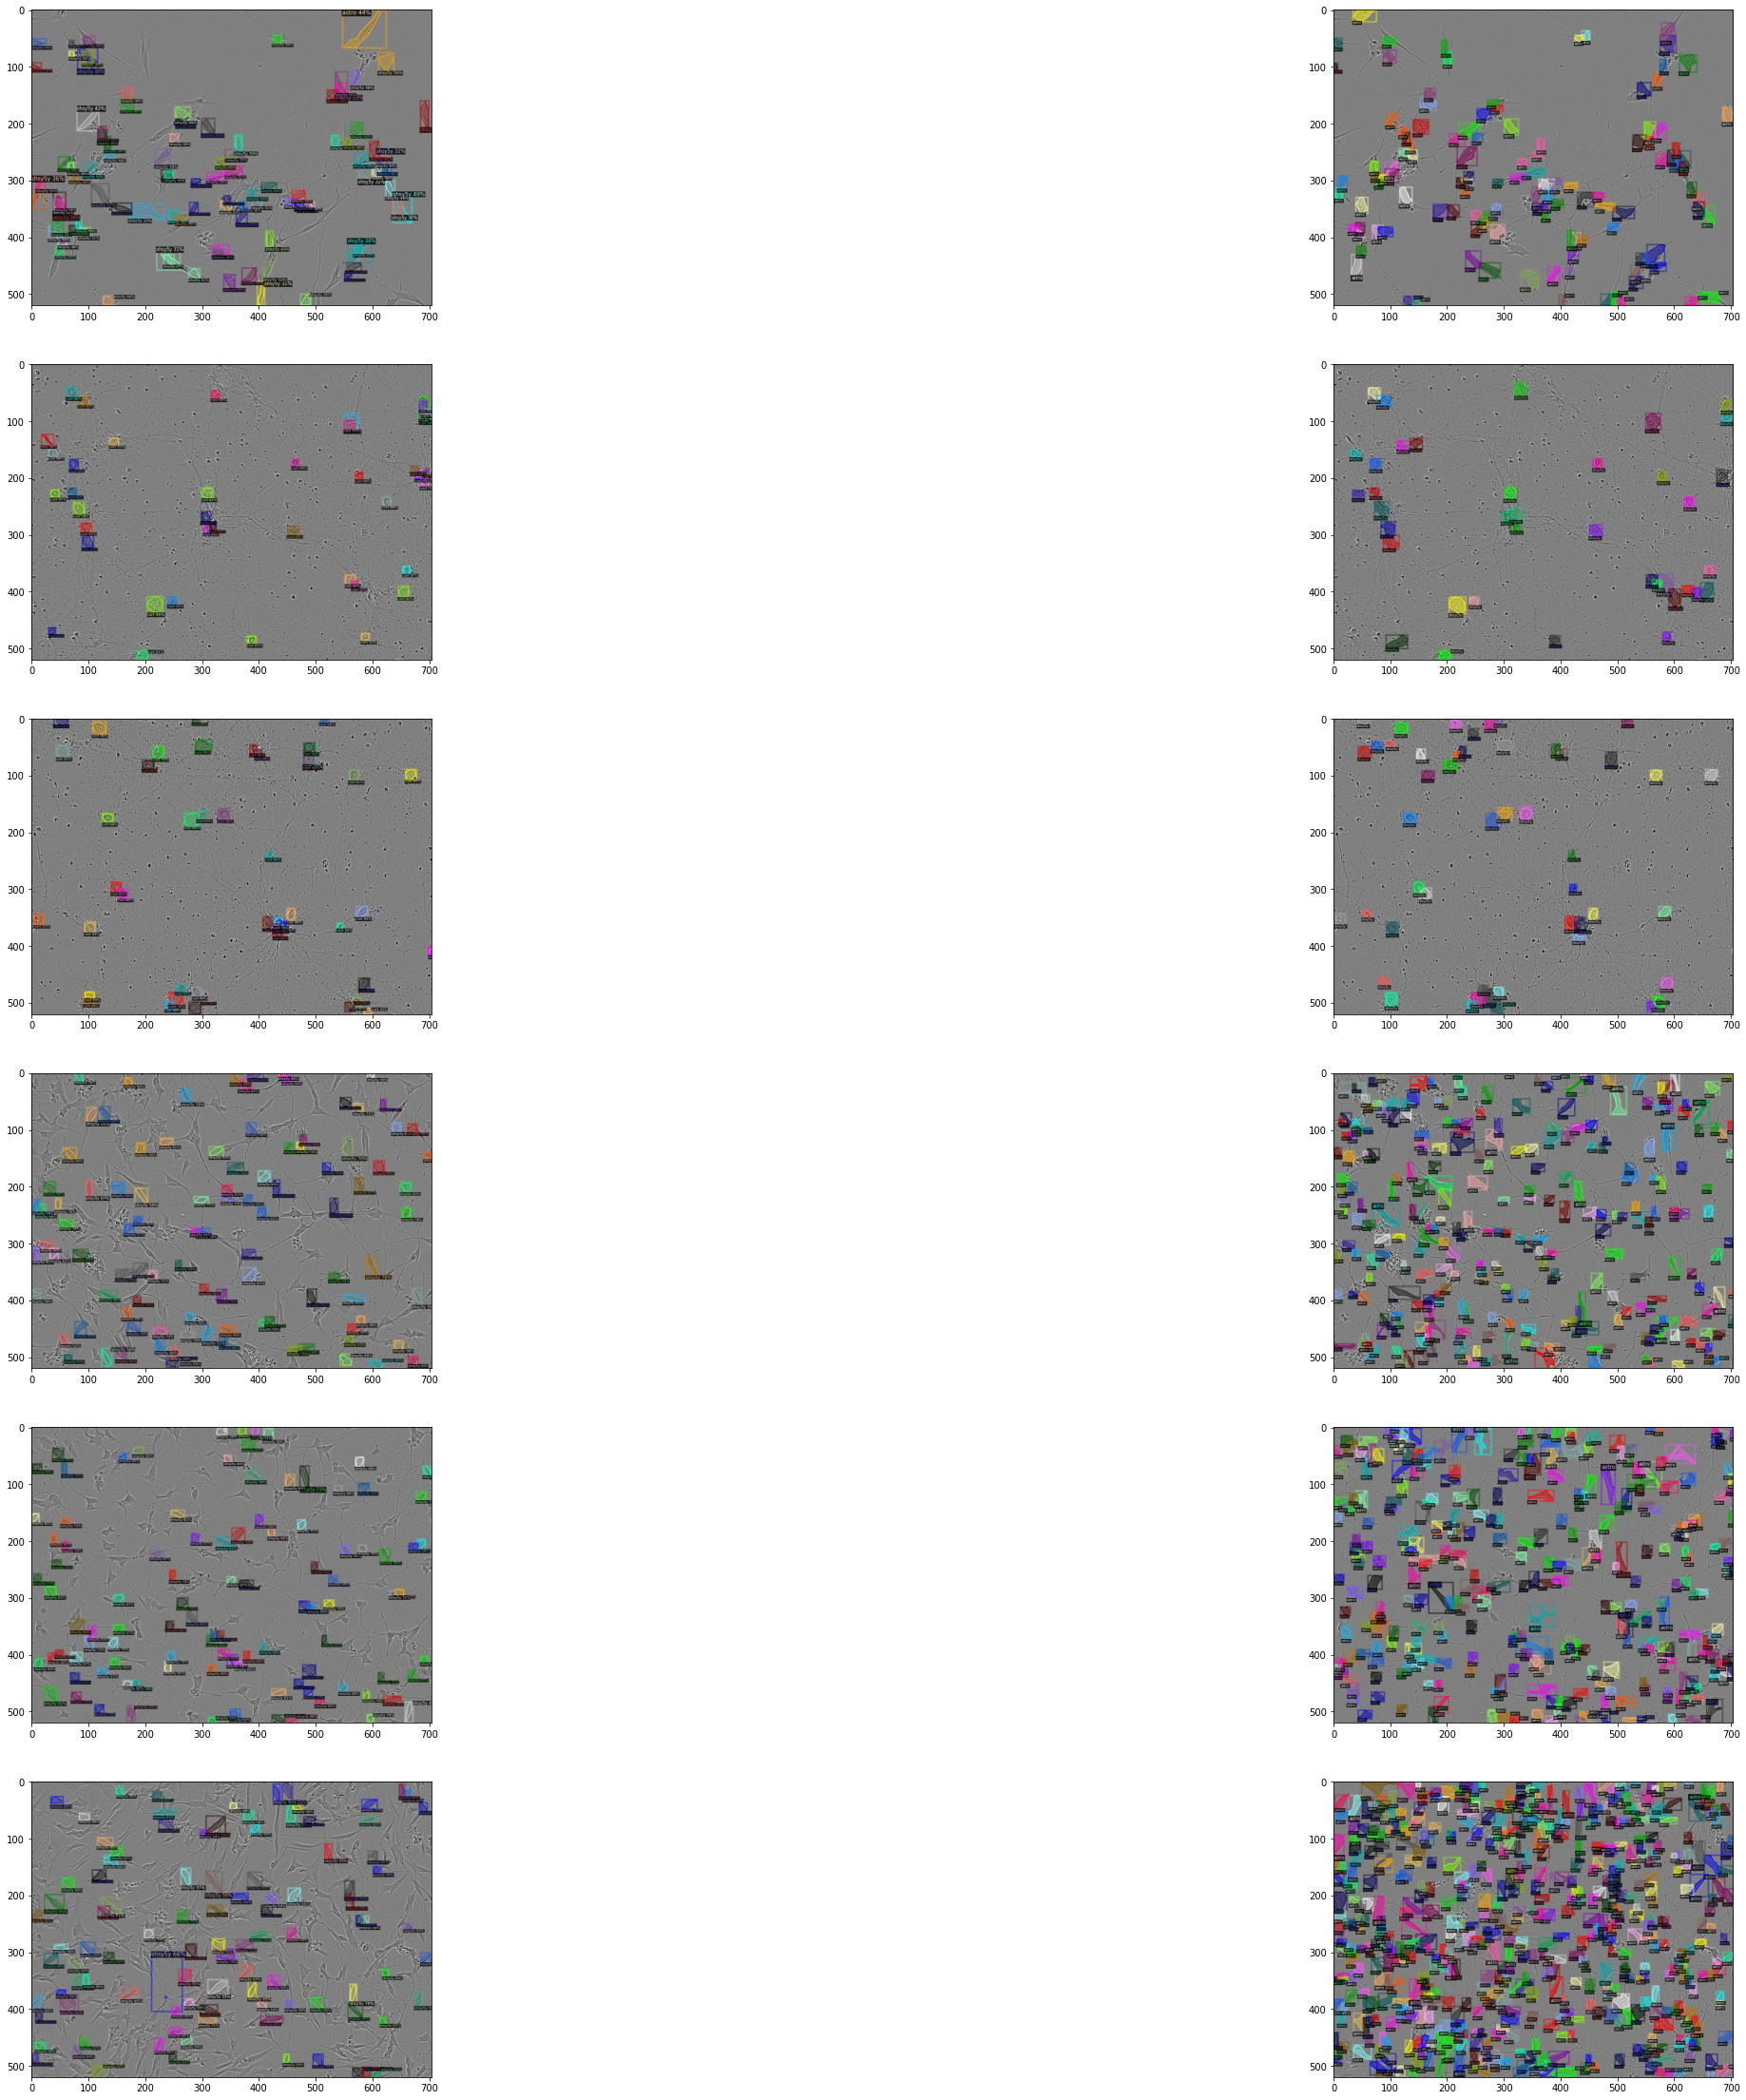

In [11]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'),

                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(45,40))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

### We can see that while it is not perfect, it did learn something
We can now take our model file and use it to generate submission in the [final notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-3-3-inference)

In [9]:
!ls ./output/model_final.pth

'ls' is not recognized as an internal or external command,
operable program or batch file.
